# Problem Statement

Among all versions of American dreams that are out there, one of the most frequently appeared terms would be homeowner. For many people, owning a home is a big deal not only financially, but in the whole life journey. However, it is not a easy process to obtain a house that fits your personal and financial needs. One of the major factor to consider would be the price of the house. 

The goal of this project is to develop a tool to estimate house price using some basic information that can be easily accessed. Of course the estimation cannot be alwasys accurate due to many other factors can play a big part in the prices, but the home buyer can at least have a good start point for the price negotiations process. 

This project will contain three main parts with focuses on EDA and feature engineering:
- **Exploratory Data Analysis (EDA)**
- **Feature Engineering**
- Model development 

# Dataset Info

## Content
The main data source for this project is a csv file that contains real estate listings in different areas of the US. It contains 10 columns showing as below:
* status: house status, either for sale or ready to build
* bed: number of bedrooms in the house
* bath: number of bathroom in the house
* acre_lot: property / land size in acres
* city: City the house residents in
* state: State the house residents in
* zip_code: postal code of the area
* house_size: house size in square feet
* prev_sold_date: the previously sold date if it is recently sold
* price: house prices (either current listing price or recently sold price)

## Acknowledgements
The data was collected from [realtor.com](https://www.realtor.com/) and special thanks to [Ahmed Shahriar Sakib](https://www.kaggle.com/ahmedshahriarsakib) for the efforts of mataining the dataset in Kaggle. 

More details about the dataset can be found: 
[USA Real Estate Dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset)

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

import string
import warnings
warnings.filterwarnings('ignore')

df_data = pd.read_csv('/kaggle/input/usa-real-estate-dataset/realtor-data.zip.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Exploratory Data Analysis

### First Glance of the dataset

In [2]:
df_data.head(3)

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0


There are 10 variables including the target variables pricing, five numerical variables and four categorical variables.

In [3]:
print(f"Numerical variables in dataset: {df_data.select_dtypes(exclude = ['object']).columns.tolist()}")
print(f"Categorical variables in dataset: {df_data.select_dtypes(include = ['object']).columns.tolist()}")

Numerical variables in dataset: ['bed', 'bath', 'acre_lot', 'zip_code', 'house_size', 'price']
Categorical variables in dataset: ['status', 'city', 'state', 'prev_sold_date']


In [4]:
df_data.describe().T

,count,mean,std,min,25%,50%,75%,max
bed,775126.0,3.332190,2.065312e+00,1.0,2.00,3.00,4.00,123.0
bath,791082.0,2.484236,1.931622e+00,1.0,2.00,2.00,3.00,198.0
acre_lot,638324.0,17.317292,9.707074e+02,0.0,0.11,0.29,1.15,100000.0
zip_code,904762.0,6519.464582,3.816713e+03,601.0,2908.00,6811.00,8854.00,99999.0
house_size,612080.0,2138.436667,3.046600e+03,100.0,1132.00,1650.00,2495.00,1450112.0
price,904895.0,877438.158334,2.457698e+06,0.0,268500.00,475000.00,830000.00,875000000.0


Note that there are some variables that are in numerical format, but actually should be categorial variables, like **zip code**. The **number of bedrooms and bathrooms** should be treated as categorial variables as well since those values are discreate, not continuous. 

There are missing values in the dataset that we need to deal with before we can build any machine learning models. The missing values counts in each variable shown below:

In [5]:
df_data.isnull().sum()

status                 0
bed               129840
bath              113884
acre_lot          266642
city                  72
state                  0
zip_code             204
house_size        292886
prev_sold_date    459101
price                 71
dtype: int64

Noticed that there are 71 missing values in the target variables **pricing**. Since the main objective of this project is to predict the price, we will remove any records with a missing pricing values. 

In [6]:
df_data.dropna(subset = 'price', inplace=True)

### Target variable

In [7]:
df_data.price.describe()

count    9.048950e+05
mean     8.774382e+05
std      2.457698e+06
min      0.000000e+00
25%      2.685000e+05
50%      4.750000e+05
75%      8.300000e+05
max      8.750000e+08
Name: price, dtype: float64

<Axes: xlabel='price'>

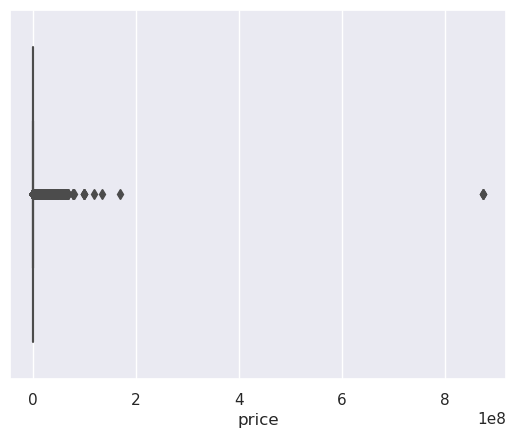

In [8]:
sns.boxplot(df_data, x = 'price')

It is difficult to see the actual distribution of the target variable due to the outliers. We will remove those outliers and create the box plot again. 

To remove the outlier for better visualization, we will remove the top 10% of high prices. 

<Axes: xlabel='price'>

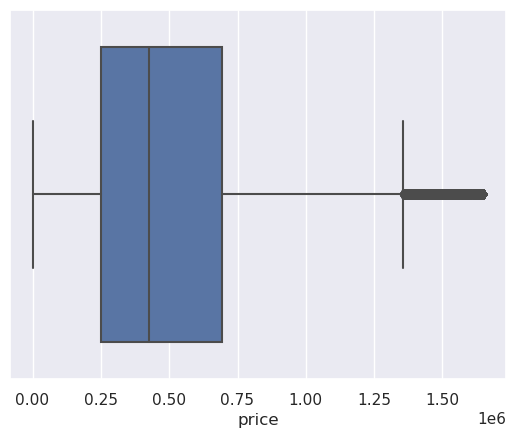

In [9]:
outlier_cutoff = df_data.price.quantile(0.9)
sns.boxplot(df_data[df_data['price']<outlier_cutoff], x = 'price')

### median home prices in different location
**Median home prices in different states**

<Axes: xlabel='price', ylabel='state'>

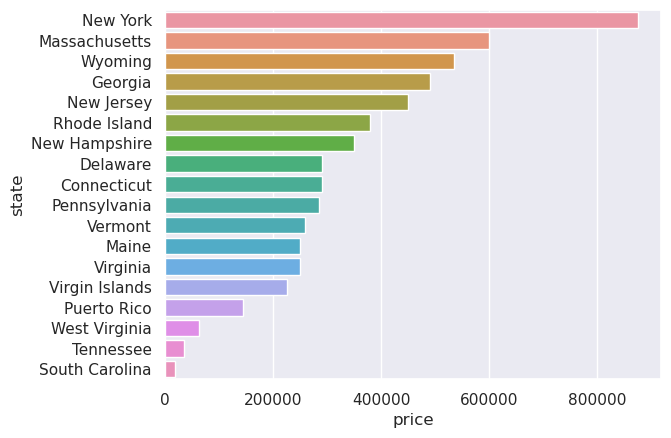

In [10]:
df = df_data.groupby('state', as_index=False)['price'].median().sort_values('price', ascending=False)
sns.barplot(data = df, x = 'price', y = 'state')

**Median home prices in top 10 most expensive cities**

<Axes: xlabel='price', ylabel='city-state'>

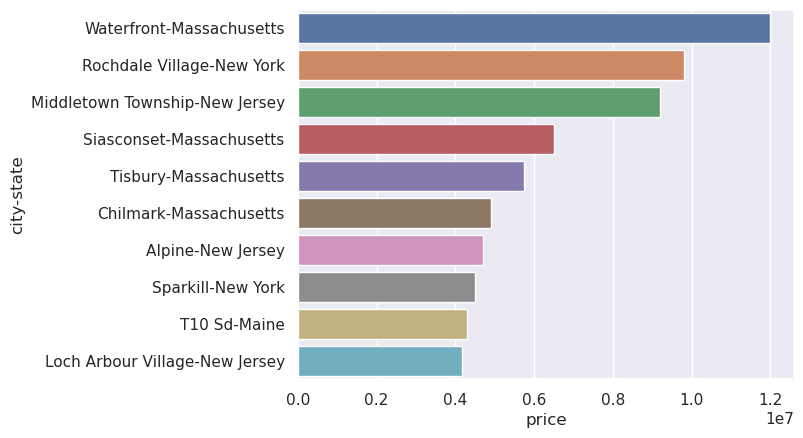

In [11]:
df = df_data.groupby(['city', 'state'], as_index=False)['price'].median().sort_values('price', ascending=False).head(10)
df['city-state'] = df['city'] + '-' +df['state'] 
sns.barplot(data = df, x = 'price', y = 'city-state')

**Median home prices in top 10 most expensive zip codes**

<Axes: xlabel='price', ylabel='zip_code-state'>

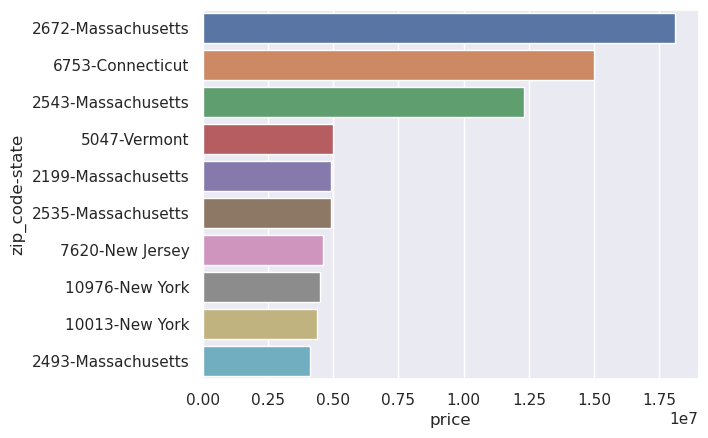

In [12]:
df = df_data.groupby(['zip_code', 'state'], as_index=False)['price'].median().sort_values('price', ascending=False).head(10)
df['zip_code-state'] = df['zip_code'].astype(int).astype(str) + '-' +df['state'] 
sns.barplot(data = df, x = 'price', y = 'zip_code-state')

From the bar chat above, we can clearly see how big the impact the location has on the house prices. 
* From states level, we can see that New York and Massachusetts are the two most expensive states. 
* For top 10 most expensive cities, we have four cities from Massachusetts, three from New Jersey, two from New York and one from Maine.
* For the top 10 most expensive zip code, we have give 5 in Massachusetts, two in New York, one in Connecticut, Vermont and New Jersey. 

### Home prices related to the house status
**Number of bedrooms**

<Axes: xlabel='bed', ylabel='price'>

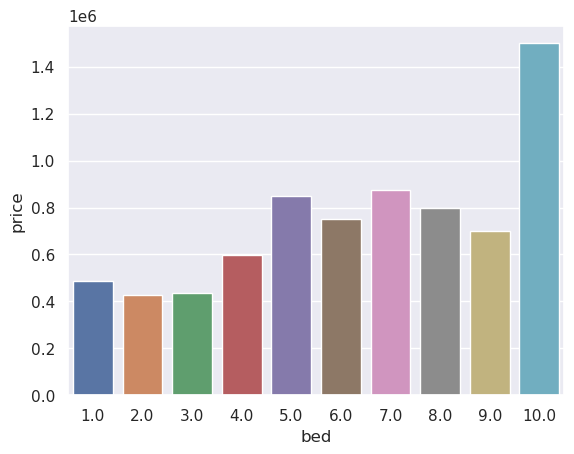

In [13]:
# to visualize how the num of bedroom could affect on the home price,
# we will combine the samples with 10 or above bedrooms together, since we only have limited amount of samples like that in the dataset
df = df_data.copy()
df.loc[df['bed']>=10, 'bed'] = 10
df_price_bed = df.groupby('bed', as_index=False)['price'].median()
sns.barplot(df_price_bed, x = 'bed', y = 'price')

When we just look at the median home price verse the number of bedrooms, we see a general up trend which means that the more bedrooms a house has, the higher median price is. **However, there is something seems odd which the median home price for one bedroom is higher that two bedrrom and three bedroom houses.**

My current thought is that there are several high living cost cities in the dataset and it generally has more one bedroom houses existed, and those could be the reason why the median price for one bedroom get skewed higher. We can dive deeper to see if this is the case.

<Axes: title={'center': 'House market for two or three bedrooms'}, ylabel='state'>

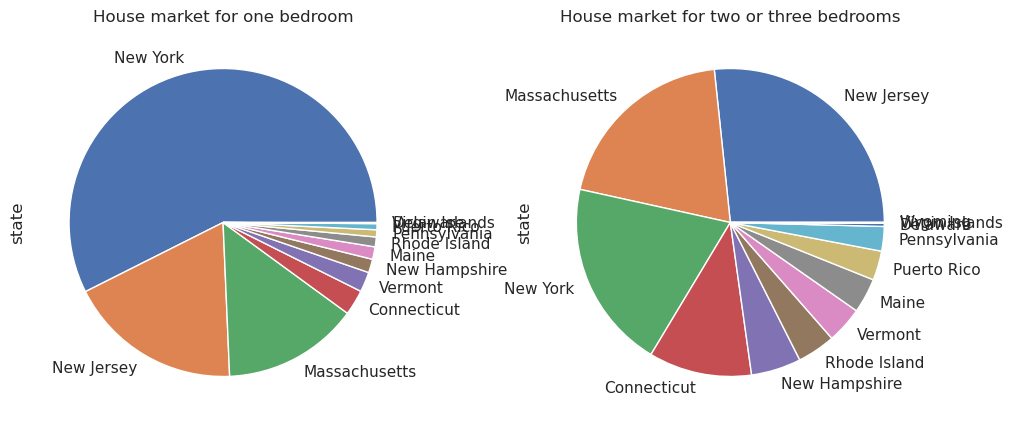

In [14]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12,5))
df_data[df_data['bed']==1].state.value_counts().plot.pie(ax = ax[0], title = 'House market for one bedroom')
df_data[df_data['bed'].isin([2, 3])].state.value_counts().plot.pie(ax = ax[1], title = 'House market for two or three bedrooms')

From the two pie charts, we can see that New York takes a much bigger potio in the one bed room house market comparing to the market for two or three bedrooms. And from the analysis prior, we know that New York is the most expensive state for housing in our data, and that explains well why we see median home price for one bedroom is higher than two or three bedroom houses. 

# Feature Engineering

Here we will clean and preprocess the given dataset. In my understanding, one way to aviod data leaking from training to testing sets is perform the feature engineering on training and testing data seperately. 

In the following section, I will test some feature enginerring methods to make the data as clean and ready as possible for model training. 

### Fill Missing values

In [15]:
df_data.isnull().sum()

status                 0
bed               129840
bath              113813
acre_lot          266571
city                  72
state                  0
zip_code             204
house_size        292886
prev_sold_date    459030
price                  0
dtype: int64

first, we will drop the samples that does not contains much valuable information, meaning there are null values for all following columns: 
* house size, 
* bedroom counts, 
* bathroom counts 
* acre lot

In [16]:
def remove_with_all_missing(df):
    '''
    Remove the records when all important features are missing,
    Here, I removed reocrds when housing size, bedroom, bathroom and acre lot are missing
    '''
    df = df[(~df['house_size'].isnull()) 
        | (~df['bed'].isnull()) 
        | (~df['bath'].isnull()) 
        | (~df['acre_lot'].isnull())]
    return df

In [17]:
df_clean = remove_with_all_missing(df_data)

**1. fill missing values for bedroom and bathroom**

<Axes: >

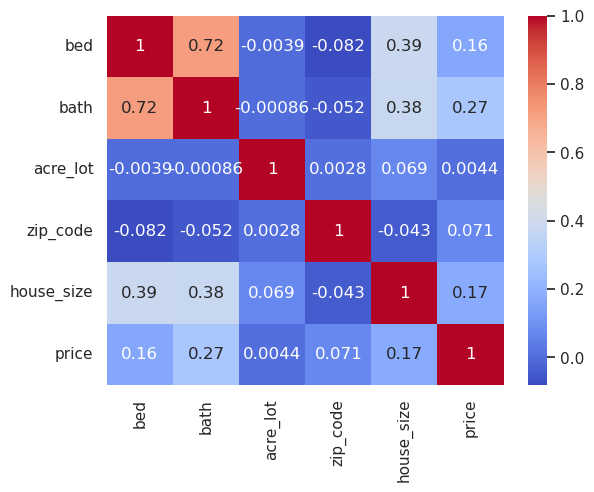

In [18]:
corr_mx = df_clean.corr()
sns.heatmap(corr_mx, annot = True, cmap = 'coolwarm')

**See from the above correlation matrix, bedrooms and bathrooms counts are highly correlated. So we can use one to help fill missing values for another. 
Also, for the rest missing values, we can fill with the most frequently appeared values for the zip code, since we normally see similar house structure or size within the same neighborhood.**

Here are some thoughts about filling the missing values for bedroom and bathroom columns:
1. We can find out the median values for bedroom / bathroom counts using bathroom/bedroom or zip code as group
2. Fill the missing values for bedroom or bathroom with median values

In [19]:
def filling_bed_bath(df):
    # first, obtain the most frequent bedroom counts using bathroom or zip code as group
    # similarity find the most frequent bathroom counts using bedroom or zip code as group
    df_mode_bed_per_bath = df.groupby(['bath'], as_index=False)['bed'].median().rename(columns = {'bed':'fill_bed_with_bath'})
    df_bed_per_zip = df.groupby('zip_code', as_index=False)['bed'].median().rename(columns = {'bed':'fill_bed_with_zip'})
    df_mode_bath_per_bath = df.groupby(['bed'], as_index=False)['bath'].median().rename(columns = {'bath':'fill_bath_with_bed'})
    df_bath_per_zip = df.groupby('zip_code', as_index=False)['bath'].median().rename(columns = {'bath':'fill_bath_with_zip'})

    df = df.merge(df_mode_bed_per_bath, on = ['bath'], how='left').merge(df_bed_per_zip, on = ['zip_code'], how='left')\
    .merge(df_mode_bath_per_bath, on = ['bed'], how='left').merge(df_bath_per_zip, on = ['zip_code'], how='left')

    # fill missing values for bedroom column with bathroom info
    df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_bath'].isnull()), 'bed'] = df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_bath'].isnull()), 'fill_bed_with_bath']
    # fill missing values for bathroom column with bedroom info
    df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_bed'].isnull()), 'bath'] = df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_bed'].isnull()), 'fill_bath_with_bed']

    # for the remaining, see if we can fill with zip code info
    df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_zip'].isnull()), 'bed'] = df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_zip'].isnull()), 'fill_bed_with_zip']
    df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_zip'].isnull()), 'bath'] = df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_zip'].isnull()), 'fill_bath_with_zip']

    df.drop(['fill_bed_with_bath','fill_bed_with_zip', 'fill_bath_with_bed', 'fill_bath_with_zip'], axis = 1, inplace=True)
    return df


In [20]:
df_clean = filling_bed_bath(df_clean)

**Fill missing values for house size and acre lot**

* From the correlation matrix, we see the house size is correlated with bedroom and bathrooms counts. We will fill the house size based on those two features along with zip code.

* In general, within the same neighborhood, the lot size are similar from each property. Here, we will use that assumption and fill the missing values for acre_lot column using zip code info.

In [21]:
def filling_house_size_lot(df):
    # first, obtain the median house size using bathroom bedroom counts as group
    # similarity find the median house size using zip code as group
    # find the median appeared lot size using zip code as group
    df_mode_house_size = df.groupby(['bath', 'bed'], as_index=False)['house_size'].median().rename(columns = {'house_size':'filled_house_size'})
    df_house_size_per_zip = df.groupby('zip_code', as_index=False)['house_size'].median().rename(columns = {'house_size':'fill_house_size_with_zip'})
    df_lot_per_zip = df.groupby('zip_code', as_index=False)['acre_lot'].median().rename(columns = {'acre_lot':'fill_acre_lot_with_zip'})

    df = df.merge(df_mode_house_size, on = ['bath', 'bed'], how='left').merge(df_house_size_per_zip, on = ['zip_code'], how='left')\
    .merge(df_lot_per_zip, on = ['zip_code'], how='left')

    # fill missing values for house size
    df.loc[(df['house_size'].isnull()) & (~df['filled_house_size'].isnull()), 'house_size'] = df.loc[(df['house_size'].isnull()) & (~df['filled_house_size'].isnull()), 'filled_house_size']
    df.loc[(df['house_size'].isnull()) & (~df['fill_house_size_with_zip'].isnull()), 'house_size'] = df.loc[(df['house_size'].isnull()) & (~df['fill_house_size_with_zip'].isnull()), 'fill_house_size_with_zip']

    # fill missing values for lot size
    df.loc[(df['acre_lot'].isnull()) & (~df['fill_acre_lot_with_zip'].isnull()), 'acre_lot'] = df.loc[(df['acre_lot'].isnull()) & (~df['fill_acre_lot_with_zip'].isnull()), 'fill_acre_lot_with_zip']
    df.drop(['filled_house_size','fill_house_size_with_zip', 'fill_acre_lot_with_zip'], axis = 1, inplace=True)
    return df

In [22]:
df_clean = filling_house_size_lot(df_clean)

**Drop the remaining missing values if there is not many**

1. colum pre_sold_date have many missing values and also it does not have any significant correlation with the house price. We will drop it from this analysis.
2. If the remaining data does not have many records with missing values, we can only keep the rows without missing values

In [23]:
df_clean.drop('prev_sold_date', axis = 1, inplace = True)

In [24]:
print(f"If we drop all records with any missing values, we will keep {round(df_clean.dropna().shape[0] / df_clean.shape[0] * 100, 2)} of rows from our data.")

If we drop all records with any missing values, we will keep 99.52 of rows from our data.


In [25]:
df_clean.dropna(inplace=True)

**After we filled the missing values and removed rows with any missing values, we end with a data frame without any missing values.**

In [26]:
df_clean.isnull().sum()

status        0
bed           0
bath          0
acre_lot      0
city          0
state         0
zip_code      0
house_size    0
price         0
dtype: int64

### Convert feature types

As we have mentioned previously, there are some variables that are in numerical format, but actually should be categorial variables, like **zip code**. The **number of bedrooms and bathrooms** should be treated as categorial variables as well since those values are discreate, not continuous. 

For the following features, we will convert them to categirical features to better present the true meanings.
* status
* city
* state

We will use label encoding to convert city and state while use one hot encoding for status. 
1. Since one hot encoding will expand the features to multi dimension, and we have many different states and cities in the dataset, we will choose label encoding to limit the features amount to aviod potential overfitting.
2. One hot encoding technic is a good option for categorical features with no perticular orders, and it could be good choice for the feature status. 

In [27]:
# label encoding for city and state
label_encoder = LabelEncoder()
df_clean['city'] = label_encoder.fit_transform(df_clean['city'])
df_clean['state'] = label_encoder.fit_transform(df_clean['state'])
# one hot encoding for status
df_clean = pd.get_dummies(df_clean, columns = ['status'])

After cleaning and preprocessing the dataset, we are now ready to move to model building.

In [28]:
df_clean.reset_index(drop = True, inplace = True)

<Axes: >

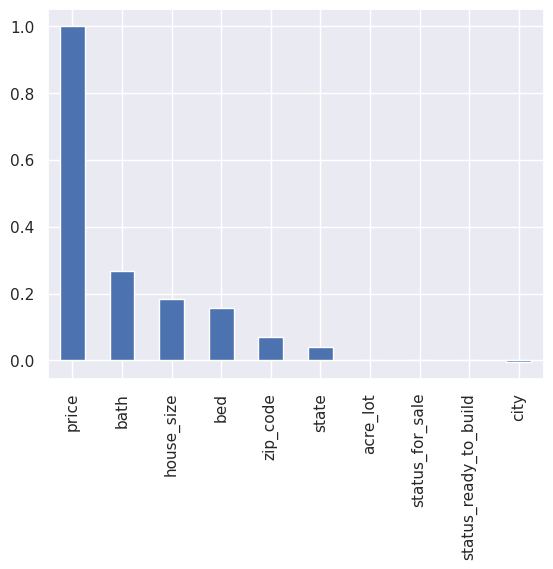

In [29]:
df_clean.corr().price.sort_values(ascending=False).plot.bar()

# Model Development

**First, get training and testing data ready**

In [30]:
X = df_clean.drop('price', axis = 1)
y = df_clean['price']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2)

**Second, we will develop a baseline model using median home price for each zip code. In case there are some missing zip code in the testing set, we will fill them with median home price for all areas.**

In [31]:
def get_scores(true_y, pred_y):
    performance = {
        'MAE':mean_absolute_error(test_y, pred_y),
        'MSE':mean_squared_error(test_y, pred_y),
        'R2-Score':r2_score(test_y, pred_y)
    }
    return performance

In [32]:
# use training set only to get the median home prices for each zip code
df_train = pd.concat([train_X, train_y], axis = 1)
df_median_per_zipcode = df_train.groupby('zip_code', as_index=False)['price'].median()

median_home_price = df_train['price'].median()

df_base_line = test_X.merge(df_median_per_zipcode, on='zip_code', how='left')
df_base_line.loc[df_base_line['price'].isnull(), 'price'] = median_home_price

baseline_performance = get_scores(test_y, df_base_line.price)

In [33]:
baseline_performance

{'MAE': 477345.5724341369,
 'MSE': 7138874827616.381,
 'R2-Score': 0.07159109108370909}

**Last, we will try random forest model and compare the performance**

In [34]:
pipe = Pipeline([('scaler', StandardScaler()), ('Random Forest Regressor', RandomForestRegressor())])
pipe.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('Random Forest Regressor', RandomForestRegressor())])

In [35]:
y_pred = pipe.predict(test_X)
rf_performance = get_scores(test_y, y_pred)

In [36]:
rf_performance

{'MAE': 38292.631562224946,
 'MSE': 193723909889.47775,
 'R2-Score': 0.9748062533446128}

**In the final section, we will compare the random forest model performace with baseline, see how much improvement we have.**

In [37]:
mae_diff = (rf_performance['MAE'] - baseline_performance['MAE']) / baseline_performance['MAE'] * 100
mse_diff = (rf_performance['MSE'] - baseline_performance['MSE']) / baseline_performance['MSE'] * 100
r2_diff = (rf_performance['R2-Score'] - baseline_performance['R2-Score']) / baseline_performance['R2-Score'] * 100

In [38]:
print("MAE improvement: {}%".format(round(mae_diff, 2)))
print("MSE improvement: {}%".format(round(mse_diff, 2)))
print("R2-Score improvement: {}%".format(round(r2_diff, 2)))

MAE improvement: -91.98%
MSE improvement: -97.29%
R2-Score improvement: 1261.63%


# Conclusion
This exercise has mainly focused on EDA and feature engineering practices. After cleaned and preprocessed the given dataset, we then build a basic random forest model to estimate the house price. As we can see from the final results, we are able to obtain a pretty decent performance. 

We can improve the performance by further hyperparameters tuning, instead of using default values for the model.

**Please let me know your thoughts on this notebook, I would like to hear any advices and suggestions. Thanks for reading! Happy learning!**
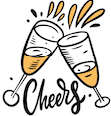
